Import required packages for homework task

In [1]:
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

import keras
from keras import callbacks
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import RMSprop, SGD

from matplotlib.colors import ListedColormap
%matplotlib inline

Using TensorFlow backend.


Change to the directory containing the images

In [2]:
path = "C:/Users/zlai/Documents/repo/HomeworkTex/ML/hw/homework 1/data/train/airplane"
os.chdir(path)

**Q1.** The inputs are feature vectors that describe the images and the output is the correct label of the image class from the set $\{\mathsf{airplane}, \mathsf{automobile}, \mathsf{bird}, \mathsf{cat}\}$.

Converting the image image into a feature vector

1. Using the raw pixel values

For each `.jpg` image, we can extract the raw pixel values using `cv2.imread` which returns an array representing the raw RGB intensities of the image. Using `.flatten()` we convert the raw image from a multi-dimensional array into a single array of values with dimensions `(3072,)`, which can be used as the input for the classification problem.

(32, 32, 3)


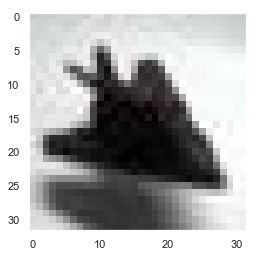

In [3]:
raw_img = cv2.imread('1.jpg')
print (raw_img.shape)
plt.imshow(raw_img)
plt.grid(False)

In [4]:
def convert2pixel_value(filename):
    """
    Converts the filename into a flatten numpy array of the raw pixel values.
    Input:
    - filename (string): name of the file to be processed.
    """
    raw_img = cv2.imread(filename)
    
    return raw_img.flatten()

In [5]:
out = convert2pixel_value('1.jpg')
print (out.shape)

(3072,)


2. Using the mean and standard deviation of each color channel

From each raw image, we can extract out the color channels (RGB), and find the mean and standard deviation value of each color. This array can be used as the feature vector for the classification problem.

In [6]:
def convert2color_mean_std(filename):
    """
    Converts the filename into the mean and standard deviation of the different color channels (RGB).
    Input:
    - filename (string): name of the file to be processed.
    """
    raw_img = cv2.imread(filename)
        
    return cv2.meanStdDev(raw_img)

In [7]:
(mean,std) = convert2color_mean_std('1.jpg')

In [8]:
print (mean)
print (std)

[[148.86035156]
 [148.71875   ]
 [148.17578125]]
[[90.06941242]
 [92.22082554]
 [91.80958747]]


3. Using a color histogram

Given a raw image, we can also extract the color histogram of the image. Depending on the number of bins chosen for the histogram, it will decide the dimension of this feature vector. For example, if we choose 8 bins for each histogram, this means that the values for each color channel will be classified into the following ranges: 0-31, 32-63, 64-95, 96-127, 128-159, 160-191, 192-223, 224-256.

In [9]:
def convert2color_hist(filename, bin):
    """
    Converts the filename into a histogram with bin bins for each of the different color channels (RGB). The concatenated 
    vector of the different color histogram is returned.
    Input:
    - filename (string): name of the file to be processed.
    - bin: number of bins for the histogram of each color channel.
    """
    raw_img = cv2.imread(filename)
    hist = []
    color = ('b','g','r')
    for channel,col in enumerate(color):
        histr = cv2.calcHist([raw_img],[channel],None,[bin],[0,256])
        hist.append(histr)
    return np.concatenate(hist)

In [10]:
output = convert2color_hist('1.jpg',bin=8)
print (output.shape)

(24, 1)


We can also use a 3D histogram as the feature vector. Depending on the choice of the number of bins, `b`, we will get a multi-dimensional array of shape `(b,b,b)`. This describes the number of pixels that have blue, green and red in the different intervals corresponding to the number of bins selected. To use it as a feature vector, we simply flatten it to get a vector of dimension `b**3`. 

In [11]:
def convert2color_3Dhist(filename, bin = 8):
    """
    Converts the filename into a 3D histogram. The 3D histogram values are then flattened to return a single dimension array.
    Input:
    - filename (string): name of the file to be processed.
    - bin: number of bins for the histogram of each color channel.
    """
    raw_img = cv2.imread(filename)
    histr = cv2.calcHist([raw_img],[0,1,2],None,[bin]*3,[0,256]*3)
        
    return histr.flatten()

In [12]:
output = convert2color_3Dhist('1.jpg')
print (output.shape)

(512,)


**Q2.** Logistic regression algorithm using stochastic gradient descent to perform binary classification

In [13]:
def load_data(path, feature = 'raw'):
    """
    Loads data into pixel values from the list of path given. Returns 
    Input:
    - path (list): list of path to load the data from.
    - feature: either 'raw' or 'hist' for raw pixel values and 3D histogram respectively.
    """
    x_train=[]
    y_train=[]
    for c,i in enumerate(path):
        os.chdir(i)
        l = os.listdir()
        for i in l:
            if feature == 'raw':
                vf = convert2pixel_value(i)
            else:
                vf = convert2color_3Dhist(i)
            x_train.append(vf)
            y_train.append(c)
    
    x_train = np.concatenate([i[np.newaxis] for i in x_train])
    y_train = np.array(y_train)
    
    # comment below to remove the shuffling of the data
    arr = np.arange(x_train.shape[0])
    np.random.shuffle(arr)
    x_train = x_train[arr]
    y_train = y_train[arr]
    
    return x_train, y_train

Define the path to the directories containing the images then load the data set using `load_data`.

In [14]:
train_bird = "C:/Users/zlai/Documents/repo/HomeworkTex/ML/hw/homework 1/data/train/bird"
train_cat = "C:/Users/zlai/Documents/repo/HomeworkTex/ML/hw/homework 1/data/train/cat"
test_bird = "C:/Users/zlai/Documents/repo/HomeworkTex/ML/hw/homework 1/data/test/bird"
test_cat = "C:/Users/zlai/Documents/repo/HomeworkTex/ML/hw/homework 1/data/test/cat"

Load the data from `bird` and `cat` folders

In [15]:
x_train, y_train = load_data([train_cat, train_bird])
x_test, y_test = load_data([test_cat, test_bird])

In [16]:
x_train.shape

(40, 3072)

We do some preprocessing of the training data by normalizing the pixel values to between $[0,1]$ and the labels to be $\{-1,+1\}$.

In [17]:
def add_bias(dataset):
    """
    Add a one to each sample for bias. Dataset must be of the form rows: samples, columns: features
    """
    n, m = dataset.shape
    out = np.ones((n, m+1))
    out[:,:-1] = dataset
    return out    

In [18]:
x_train = x_train/255
x_test = x_test/255
y_train = y_train*2 - 1
y_test = y_test*2 - 1

In [19]:
x_train = add_bias(x_train)
x_test = add_bias(x_test)

In [20]:
print (x_train.shape[0], 'training samples')
print (x_test.shape[0], 'test samples')

40 training samples
40 test samples


Define some basic functions for computing the loss and gradient of the model

In [21]:
def sigmoid(x):
    """
    Applies the sigmoid function on the given vector.
    Input(s):
    - x : numpy vector of values
    """
    return 1/(1+np.exp(-x))

In [22]:
def initialize_params(size=3073, seed=123):
    """
    Initialize parameters W weights and b biases.
    Input(s):
    - size (int): size of the parameters
    - seed (int): seed for the random number generator
    """
    rng = np.random.RandomState(seed)
    
    return rng.normal(size=(size,))

In [23]:
def log_loss(x_train, y_train, W):
    """
    Computes the loss value of the logistic loss.
    Input(s):
    - x_train, y_train: training data and labels. x_train takes different forms depending on the features used and y_train
                        is {-1,+1}.
    - W: value of the parameters.                    
    """
    z = y_train * np.dot(x_train, W)
    h = sigmoid(z)
    
    return -np.mean(np.log(h))   

In [24]:
x_train

array([[0.15686275, 0.30588235, 0.49411765, ..., 0.48235294, 0.62745098,
        1.        ],
       [0.0745098 , 0.01176471, 0.03921569, ..., 0.09019608, 0.10196078,
        1.        ],
       [0.69803922, 0.70980392, 0.76470588, ..., 0.81960784, 0.83921569,
        1.        ],
       ...,
       [0.43137255, 0.49411765, 0.52156863, ..., 0.49019608, 0.46666667,
        1.        ],
       [0.76862745, 0.77647059, 0.80784314, ..., 0.72941176, 0.7372549 ,
        1.        ],
       [0.28627451, 0.39607843, 0.4       , ..., 0.2627451 , 0.3372549 ,
        1.        ]])

In [25]:
W = initialize_params(seed=1) * 0.01
print (W)
log_loss(x_train, y_train, W)

[ 0.01624345 -0.00611756 -0.00528172 ...  0.01377667  0.00636284
  0.00055297]


0.7008910508715915

In [26]:
def log_grad(x_train, y_train, W):
    """
    Computes the gradient of the logistic loss function.
    Input(s):
    - x_train, y_train: training data and labels. x_train takes different forms depending on the features used and y_train
                        is {-1,+1}.
    - W: value of the parameters.                    
    """
    z = y_train * np.dot(x_train, W)
    h = sigmoid(z)
    n = x_train.shape[0]
    
    return 1/n * np.dot(x_train.T,(y_train * (h-1)))    

In [27]:
def next_batch(x_train, y_train, batch_size=2):
    """
    Returns a batch of size batch_size for stochastic gradient descent.
    - x_train, y_train: training data and labels. x_train takes different forms depending on the features used and y_train
                        is {-1,+1}.
    - batch_size (int): size of each batch.                    
    """
    for i in np.arange(0, x_train.shape[0], batch_size):
        yield (x_train[i:i+batch_size],y_train[i:i+batch_size])


In [28]:
def log_classifier(x_test, learnt_W):
    """
    Takes in the test set and learnt parameters and returns the accuracy of the classifier on the test set.
    Inputs:
    -
    """
    return (sigmoid(np.dot(x_test, learnt_W)) >= .5) * 2 - 1

In [29]:
def log_accuracy(x_test, y_test, learnt_W):
    """
    Returns the accuracy of the model with parameters learnt_W.
    Input(s):
    - 
    """
    output = log_classifier(x_test, learnt_W)
    return np.sum(np.absolute(y_test - output) == 0)/y_test.shape[0]

In [30]:
def log_train(x_train, y_train, x_test, y_test, W, alpha=0.01, batch_size = 4, epoch = 100):
    """
    Trains the model with given learning rate alpha, batch_size, epoch and initialized parameters W.
    """
    loss_history = []
    train_acc_history = []
    test_acc_history = []
    for e in np.arange(epoch):
        epoch_loss = []
        for (batchx, batchy) in next_batch(x_train, y_train):
            loss = log_loss(batchx, batchy, W)
            grad = log_grad(batchx, batchy, W)
            epoch_loss.append(loss)
            W += -alpha * grad
        loss_history.append(np.average(epoch_loss))
        train_acc = log_accuracy(x_train, y_train, W)
        test_acc = log_accuracy(x_test, y_test, W)
        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)
    
    return loss_history, train_acc_history, test_acc_history, W    

In [31]:
def log_plot(loss_history, train_acc_history, test_acc_history):
    """
    Plots out the loss function value for the different epochs and the accuracy of the test set for the 
    parameters learnt in the different epochs.
    Input(s):
    - loss_history: list containing the change in the loss value over the epochs
    - acc_history: list containing the accuracy value of the test set over the epochs
    """
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
    ax1.plot(loss_history, color='r')
    # ax1.plot(model_log.history['val_acc'])
    ax1.set_title('Loss (Lower Better)')
    ax1.set(xlabel='Epoch', ylabel='Loss')
    ax1.legend(['train', 'validation'], loc='upper right')

    ax2.plot(train_acc_history)
    ax2.plot(test_acc_history)
    ax2.set_title('Accuracy (Higher Better)')
    ax2.set(xlabel='Epoch', ylabel='Accuracy')
    ax2.legend(['train', 'test'], loc='center right')

In [32]:
W = initialize_params(seed=1)
loss_history, train_acc_history, test_acc_history, learnt_W = log_train(x_train, y_train, x_test, y_test, W, epoch=100)

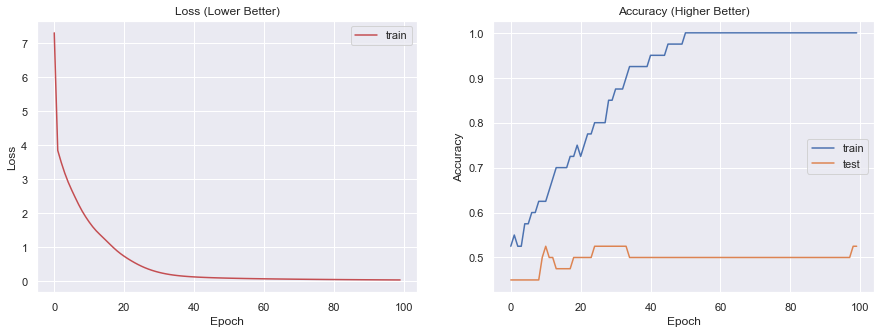

In [33]:
log_plot(loss_history, train_acc_history, test_acc_history)

3D histogram

In [34]:
xh_train, yh_train = load_data([train_cat, train_bird], feature = None)
xh_test, yh_test = load_data([test_cat, test_bird], feature=None)

In [35]:
print (xh_train.shape)

(40, 512)


In [36]:
# xh_train = xh_train/1024
# xh_test = xh_test/1024
yh_train = yh_train*2 - 1
yh_test = yh_test*2 - 1

In [37]:
xh_train = add_bias(xh_train)
xh_test = add_bias(xh_test)

In [38]:
print (xh_train.shape)

(40, 513)


In [39]:
Wh = initialize_params(size = xh_train.shape[1], seed=1)
loss_historyh, train_acc_historyh, test_acc_historyh, learnt_Wh = log_train(xh_train, yh_train, xh_test, yh_test, Wh, epoch=100)

C:\Users\zlai\AppData\Local\Continuum\anaconda3\envs\mlhw\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


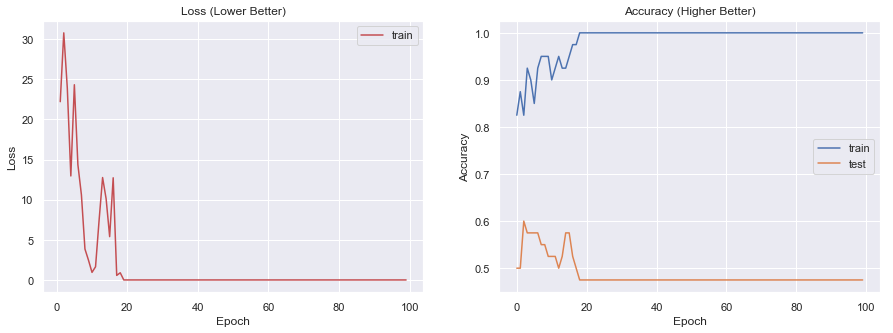

In [40]:
log_plot(loss_historyh, train_acc_historyh, test_acc_historyh)

**Q3.** Hinge loss with stochastic gradient descent to perform binary classification